**Objetivo**: Treinar uma rede neural convolucional para identificar o tipo de tecido


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH = '/content/gdrive/Shareddrives/IA901 - Projeto Final/'

Mounted at /content/gdrive


In [2]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import time
import os
import copy
from sklearn import metrics
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image

torch.manual_seed(42) # semente aleatoria!!!

plt.ion()   # interactive mode

In [3]:
def MakeREADME(file_path, text):
  path = file_path+"/README.txt"  # File path and name
  # Open the file in write mode
  file = open(path, "w")
  # Write the text to the file
  file.write(text)
  # Close the file
  file.close()

In [4]:
# ______________________________________________________________________________
# Cria pasta para salvar resultados do experimento como um todo
import os

ExperimentName = 'Experiment_I'

os.makedirs(PATH+"Notebooks/InterimResults/CellCounting/", exist_ok=True) # Pasta do experimento

path_interim = PATH+"Notebooks/InterimResults/CellCounting/{}".format(ExperimentName)
if not os.path.exists(path_interim):
  print('Criar pasta chamada {}? (yes/no)'.format(ExperimentName))
  Answer2 = str (input())

  if Answer2=='yes':
    os.mkdir(path_interim)
    print('Resuma o conteudo deste grande experimento. Qual a sua principal diferença para os demais?')
    text = str (input())
    MakeREADME(path_interim, text)

# ______________________________________________________________________________
# Cria subdiretorio para salvar resultados dos subexperimentos
print('Quer criar um novo sub_experimento? (True/False)')
NewSubExperiment = str (input())

if NewSubExperiment=='True':

  Experiment_Number = len(next(os.walk(path_interim))[1])
  subpath = path_interim+'/{}'.format(Experiment_Number+1)
  os.mkdir(subpath)

  print('Resuma o conteudo deste sub experimento. Qual a sua principal mudança feita')
  text = str (input())
  MakeREADME(subpath, text)

else:

  print('Diga o numero do experimento que você gostaria de refazer (Experiment_Number)')
  Experiment_Number = str (input())
  subpath = path_interim+'/{}'.format(Experiment_Number)


Quer criar um novo sub_experimento? (True/False)
False
Diga o numero do experimento que você gostaria de refazer (Experiment_Number)
1


# Configurações gerais e funções úteis para as análises

In [5]:
def Variable_x_Epochs(Epochs, Variable1, Variable2, metricname):
  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(Epochs, Variable1, label='Train')
  ax.plot(Epochs, Variable2, label='Val')
  ax.set_xlabel('Epochs', fontsize=15)
  ax.set_ylabel('{}'.format(metricname), fontsize=15)
  plt.legend()
  ax.grid()
  plt.savefig(subpath+'/Epochsx{}.png'.format(metricname))
  plt.show()

In [6]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    LOSS_train = []
    LOSS_val = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    best_epoch = 0
    epoch_loss = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            BatchTotalSize = len(dataloaders[phase])

            batch_counter = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        batch_counter = batch_counter + 1
                        print('\r Steps: {} out {}'.format(batch_counter, BatchTotalSize), end=" ")
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            if phase == 'train' and scheduler!=None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss: # criterio de minimizacao do loss
                print('Best model detected!')
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                LOSS_train.append(epoch_loss)
            if phase == 'val':
                LOSS_val.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    print('Best model (epoch={}): val Loss: {:5f}'.format(best_epoch, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, LOSS_train, LOSS_val


## Carregar dados


In [7]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, 'Image_'+str(self.data['Unnamed: 0'].iloc[idx])+'.png')
        image = Image.open(img_name).convert('RGB')  # Load the image

        target1 = self.data[['CancerCells']].iloc[idx].values[0]  # Get the first target value
        target2 = self.data[['TotalCells']].iloc[idx].values[0]  # Get the second target value

        target = np.array([target1, target2])
        #print('target: ', target)

        if self.transform is not None:
            image = self.transform(image)

        return image, torch.from_numpy(target) #torch.from_numpy(target1), torch.from_numpy(target2)


In [8]:
size, padding = 224, 60 # tamanho de entrada da EfficientNet B1
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((size,size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        #transforms.Pad(padding),
        #transforms.RandomCrop(size, padding,padding_mode='reflect'),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor()
    ])
}

In [9]:
TrainDF = pd.read_csv(PATH+"Datasets/Processed/CellCounting/TrainLabels.csv")
ValDF = pd.read_csv(PATH+"Datasets/Processed/CellCounting/ValLabels.csv")

train_dir = PATH+'Datasets/Processed/CellCounting/train/'
val_dir = PATH+'Datasets/Processed/CellCounting/val/'

image_datasets = {'train': CustomDataset(TrainDF, train_dir, data_transforms['train']), 'val': CustomDataset(ValDF, val_dir, data_transforms['val'])}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dataset_sizes)

{'train': 5537, 'val': 781}


In [10]:
# for inputs, target in dataloaders['train']:
#   print("image:", inputs)
#   print("Target 1:", target)

# Experimento:



In [ ]:
model = models.efficientnet_b0(weights=True)
model.classifier[1] = nn.Linear(in_features= model.classifier[1].in_features, out_features=2)

model = model.to(device)

criterion = nn.MSELoss()
criterion = criterion.to(device)

num_epochs = 70 # epochs
lr=1e-4 # learning rate

# Observe that all parameters are being optimized
optimizer_model = optim.Adam(model.parameters(), lr=lr)

summary(model, (3, size, size))

In [12]:
print("Hyperparameters Summary \n")
print("Learning Rate: ", lr)
print("Optmizer: ADAM")
print("Loss Function: Mean Squared Error")
print("N Epochs: ", num_epochs)

Hyperparameters Summary 

Learning Rate:  0.0001
Optmizer: ADAM
Loss Function: Mean Squared Error
N Epochs:  70


In [15]:
model, LOSS_train, LOSS_val = train_model(model, criterion, optimizer_model,num_epochs=num_epochs)

# Saving model
PATH = subpath+'/Trained_DLModel.pt'
torch.save(model.state_dict(),PATH)

Epoch 0/69
----------
 Steps: 347 out 347 train Loss: 307.5309
val Loss: 143.5302
Best model detected!
Epoch 1/69
----------
 Steps: 347 out 347 train Loss: 128.3716
val Loss: 64.4397
Best model detected!
Epoch 2/69
----------
 Steps: 347 out 347 train Loss: 80.6434
val Loss: 57.6562
Best model detected!
Epoch 3/69
----------
 Steps: 347 out 347 train Loss: 66.7157
val Loss: 39.8764
Best model detected!
Epoch 4/69
----------
 Steps: 347 out 347 train Loss: 60.7107
val Loss: 71.8836
Epoch 5/69
----------
 Steps: 347 out 347 train Loss: 57.8492
val Loss: 56.1708
Epoch 6/69
----------
 Steps: 347 out 347 train Loss: 50.4604
val Loss: 45.2721
Epoch 7/69
----------
 Steps: 347 out 347 train Loss: 46.7170
val Loss: 34.7063
Best model detected!
Epoch 8/69
----------
 Steps: 347 out 347 train Loss: 45.8014
val Loss: 68.7185
Epoch 9/69
----------
 Steps: 347 out 347 train Loss: 44.3085
val Loss: 33.0331
Best model detected!
Epoch 10/69
----------
 Steps: 347 out 347 train Loss: 41.3517
val Loss

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffab2aeb880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffab2aeb880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

val Loss: 49.0027
Epoch 16/69
----------
 Steps: 35 out 347 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffab2aeb880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffab2aeb880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

 Steps: 347 out 347 train Loss: 27.3755
val Loss: 28.7267
Best model detected!
Epoch 17/69
----------
 Steps: 347 out 347 train Loss: 25.7475
val Loss: 28.0256
Best model detected!
Epoch 18/69
----------
 Steps: 347 out 347 train Loss: 23.7064
val Loss: 25.8382
Best model detected!
Epoch 19/69
----------
 Steps: 347 out 347 train Loss: 24.3135
val Loss: 28.9220
Epoch 20/69
----------
 Steps: 347 out 347 train Loss: 21.6608
val Loss: 40.0654
Epoch 21/69
----------
 Steps: 347 out 347 train Loss: 23.0996
val Loss: 30.1532
Epoch 22/69
----------
 Steps: 347 out 347 train Loss: 20.6190
val Loss: 24.9705
Best model detected!
Epoch 23/69
----------
 Steps: 347 out 347 train Loss: 21.3597
val Loss: 22.4629
Best model detected!
Epoch 24/69
----------
 Steps: 347 out 347 train Loss: 19.6452
val Loss: 21.9628
Best model detected!
Epoch 25/69
----------
 Steps: 347 out 347 train Loss: 17.8155
val Loss: 29.0558
Epoch 26/69
----------
 Steps: 347 out 347 train Loss: 16.3368
val Loss: 33.7227
Epoch 

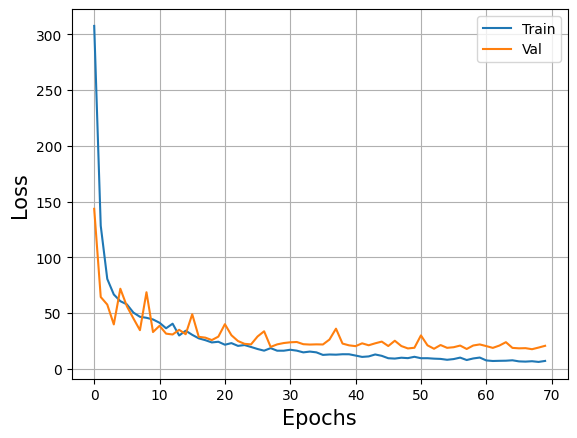

In [25]:
# Plot curves:
Epochs = np.arange(0,num_epochs)

# Loss Curves:
Variable_x_Epochs(Epochs, LOSS_train, LOSS_val, "Loss")

In [26]:
# Saving a copy of the experiment notebook
import shutil

source_file = '/content/gdrive/Shareddrives/IA901 - Projeto Final/Notebooks/02_TrainTissueClassification.ipynb'

# Copy the file to the destination directory
shutil.copy2(source_file, subpath)

'/content/gdrive/Shareddrives/IA901 - Projeto Final/Notebooks/InterimResults/CellCounting/Experiment_I/1/02_TrainTissueClassification.ipynb'